**Предполагается использование Python версии 3.5 или выше и PyTorch 1.0**

# 3 Задание

## Восстановление коэффициента

Сначала попробуем восстановить функцию $ \hat{f}$.

In [63]:
import json
import os

import numpy as np

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 10, 9

In [2]:
with open(os.path.join(".", "Regression_test.json")) as file:
    data = json.load(file)

In [3]:
print(data.keys())

dict_keys(['x', 'y'])


In [4]:
train_data = np.array((data["x"], data["y"])).transpose()
train_data = train_data[train_data[:,0].argsort()]

Построим график по данным.

Text(0, 0.5, 'y')

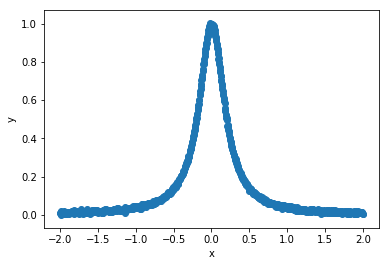

In [5]:
fig = plt.figure()
plt.scatter(train_data[:, 0], train_data[:, 1], figure=fig)
plt.xlabel("x")
plt.ylabel("y")

Из графика видно, что данные представляют собой нелинейную зависимость. Для восстановления функция нужна нелинейная регрессия. Определим для этого нейронную сеть с помощью PyTorch.

In [6]:
import torch
import torch.nn.functional as F

torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
xdata = torch.tensor(np.resize(train_data[:,0], (-1, 1)))
ydata = torch.tensor(np.resize(train_data[:,1], (-1, 1)))

In [8]:
class RegressionNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Bilinear(n_hidden, n_hidden, n_output)


    def forward(self, x):
        x = self.hidden(x)     
        x = F.relu(x)
        x = self.predict(x, -x)        
        return x

net = RegressionNet(n_feature=1, n_hidden=90, n_output=1)    
print(net)  

optimizer = torch.optim.LBFGS(net.parameters(), lr=0.5, max_iter=25)
loss_func = torch.nn.SmoothL1Loss() 

RegressionNet(
  (hidden): Linear(in_features=1, out_features=90, bias=True)
  (predict): Bilinear(in1_features=90, in2_features=90, out_features=1, bias=True)
)


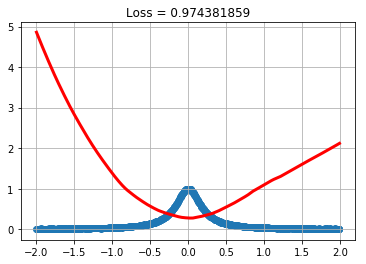

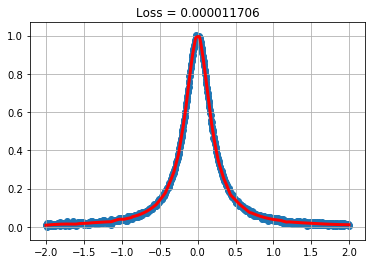

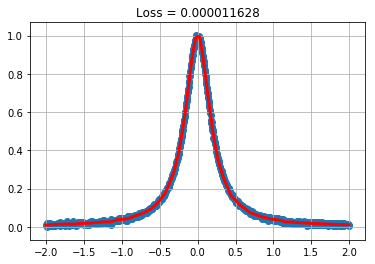

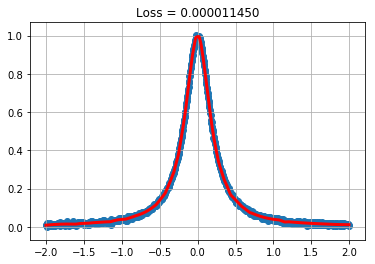

In [9]:
for t in range(200):
    def closure():
        optimizer.zero_grad()
        output = net(xdata)
        loss = loss_func(output, ydata)
        loss.backward()
        return loss
    
    optimizer.step(closure)

       
    if t % 50 == 0:
        out = net(xdata)
        loss = loss_func(out, ydata)
        plt.cla()
        plt.scatter(xdata.data.numpy(), ydata.data.numpy())
        plt.plot(xdata.data.numpy(), out.data.numpy(), 'r-', lw=3)
        plt.grid(True)
        plt.title('Loss = %.9f' % loss.item())
        plt.pause(0.01)

plt.show()

По результаттам видно, что нейронная есть достаточно хорошо аппркосимировала данные в диапазоне $ [-2;2]$. За пределами этого диапазона значение функции по данным скорее всего должно быть близко к 0. По мере удаления от 0 функция стремиться к 0. Нейронная есть предсказывает совсем другие значения.

In [10]:
with torch.no_grad():
    x = -5
    print("x =", x, "y =", net(torch.Tensor([[x]])), sep=" ")
    x *= -1
    print("x =", x, "y =", net(torch.Tensor([[x]])), sep=" ")
    

x = -5 y = tensor([[6.1961]])
x = 5 y = tensor([[0.3497]])


Поьзоваться нейронной сетью за пределами отрезка от $ [-2; 2] $ не стоит. Можно сделать вывод, что модель обладает плохой обощающей способностью.

Найдём значение $ k = \hat{f}(2,1) $.

In [11]:
with torch.no_grad():
    k = net(torch.Tensor(([2.1])))
    print(k.item())

0.011125906741179026


## Исследование устойчивости

Рассмотрим систему:
$$
x^{(4)} + 4x^{(3)}+2x^{(3)}+2x^{(2)}+3x^{(1)} + k x^{(0)} = g(t)
$$

Система является линейной стационарной. Для исследования устойчивости на отрезке воспользуемся критерием Гурвица. 
Определитель:
$$
\vartriangle = 
\begin{pmatrix}
4 & 3 & 0 & 0 \\
1 & 2 & k & 0\\
0 & 4 & 3 & 0\\
0 & 1 & 2 & k
\end{pmatrix}
$$

Угловые миноры:
$ \vartriangle_1 = \vert 4 \vert > 0,\vartriangle_2 = \begin{pmatrix}
4 & 3 \\
1 & 2
\end{pmatrix} >0 , \vartriangle_3 = 15 - 16 \cdot k, \vartriangle_4 = k \cdot (15 - 16 k).$ 

Значение углового минора $ \vartriangle_3 $:

In [12]:
15 - 16 * k.item()

14.821985492141135

Значение углового минора $ \vartriangle_4 $:

In [13]:
k.item() *  (15 - 16 * k.item())

0.16490802830467077

Все угловые миноры больше 0, поэтому система асимптотически устойчивая.

Из-за того что порядок правой части дифференциального оператора меньше, чем порядок левой части то система устойчива по входу т. е. реакция системы при ограниченном $ g(t) $ также является ограниченным.

## Моделирование системы при разных входных воздействиях

Сначала необходимо преобразовать линейное дифференциальное уравнение 4-го порядка в систему дифференциальных уравнений. Введём функции $ z_1,\ldots,z_4$:

$$
z_1 = x,\\
x^{(1)} =z_1^\prime = z_2,\\
x^{(2)} =z_2^\prime=z_3,\\
x^{(3)} =z_3^\prime=z_4,\\
z_4^\prime = x^{(4)} =g - 4 z_4 -2 z_3 -3 z_2 -k z_1,\\
z_1(t_0) = x(t_0),\\
z_2(t_0) = x^{(1)}(t_0),\\
z_3(t_0) = x^{(2)}(t_0),\\
z_4(t_0) = x^{(3)}(t_0).
$$

Новая системы:
$$
z_1^\prime = z_2,\\
z_2^\prime=z_3,\\
z_3^\prime=z_4,\\
z_4^\prime = g - 4 z_4 -2 z_3 -3 z_2 -k z_1,\\
z_1(t_0) = x(t_0),\\
z_2(t_0) = x^{(1)}(t_0),\\
z_3(t_0) = x^{(2)}(t_0),\\
z_4(t_0) = x^{(3)}(t_0).
$$

In [14]:
import math

from scipy import integrate

In [80]:
def create_right_part(g):
    def fun(t: float, z: np.array):
        return np.array([z[1], z[2], z[3], g(t) - 4 * z[3] - 2 * z[2] - 3 * z[1] - k * z[0]])
    fun._label = g._label
    return fun

In [87]:
def g_sin(t: float):
    return math.sin(t)

def g_cos(t: float):
    return math.cos(t)

def g_const(t: float):
    return 2.0

In [88]:
g_sin._label = "sin(t)"
g_cos._label = "cos(t)"
g_const._label = "5"

functions = (g_sin, g_cos, g_const)
right_parts = tuple(map(create_right_part, functions))

In [89]:
# Начальные условия
y0 = np.array((2, 1, 0, 0), dtype=float)

In [92]:
def plot(right_parts, gs):
    for rp, g in zip(right_parts, gs):
        solution = integrate.solve_ivp(rp, (0, 10), y0, method="RK45")
        fig, axes = plt.subplots(1, 2, gridspec_kw={"wspace": 0.5})
        axes[1].plot(solution.t, solution.y[0, :], label="Выход при воздействии {}".format(rp._label))
        axes[0].plot(solution.t, tuple(map(g, solution.t)), label="Выходное воздействие")
        axes[0].set_xlabel("t")
        axes[0].set_ylabel("g(t) = {}".format(g._label))
        axes[1].set_xlabel("t")
        axes[1].set_ylabel("x(t)")
        axes[0].grid(True)
        axes[1].grid(True)
        
        

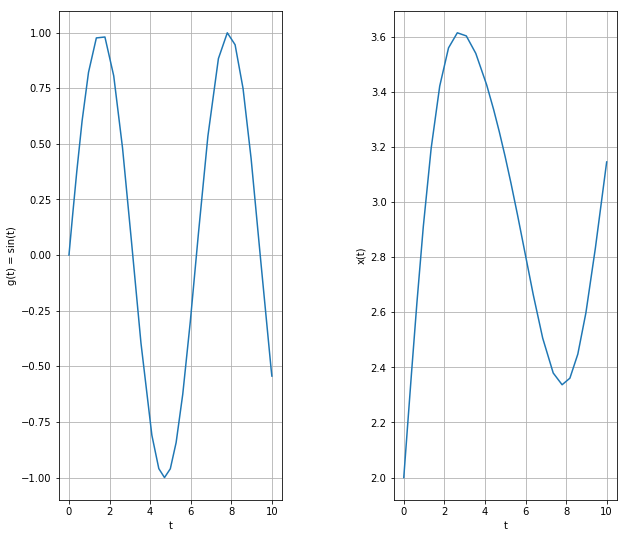

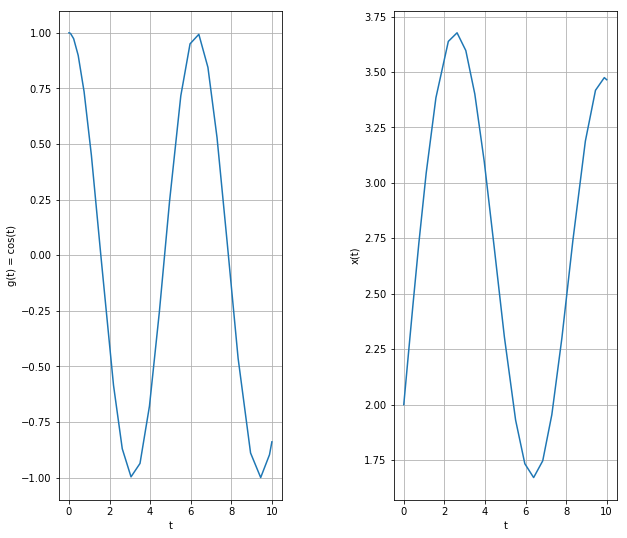

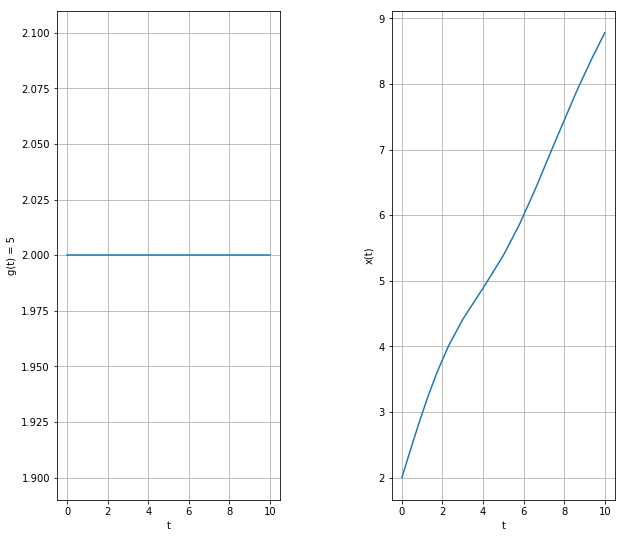

In [93]:
plot(right_parts, functions)